In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve, f1_score, precision_recall_fscore_support

import gensim.downloader as api

import os
import joblib

In [ ]:
#pip install -q -U "tensorflow-text==2.8.*"
#pip install -q tf-models-official==2.7.0
#pip install tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
mod_data = pd.read_csv('EDA_processed_data.csv', index_col=0, engine='c')

mod_data.head()

,Query,SQLIA,char_len,word_len,small,has_keywords,is_complete_query,one_word,query_proc,always_true,sent_pol,entropy
0,""" or pg_sleep ( __TIME__ ) --",True,33,7,""" or pg_sleep ( __time__ ) --",True,False,False,""" or pg_sleep ( __TIME__ ) --",False,0.0,2.807355
1,create user name identified by pass123 tempora...,True,90,12,create user name identified by pass123 tempora...,True,True,False,create user name identified by pass<num> tempo...,False,0.0,3.418296
2,AND 1 = utl_inaddr.get_host_address ( ...,True,218,35,and 1 = utl_inaddr.get_host_address ( ...,True,False,False,AND <num> = utl_inaddr.get_host_address (...,True,0.3,3.987164
3,select * from users where id = '1' or @ @1 ...,True,90,20,select * from users where id = '1' or @ @1 ...,True,False,False,select * from users where id = '<num>' or @...,False,0.0,4.121928
4,"select * from users where id = 1 or 1#"" ( ...",True,85,18,"select * from users where id = 1 or 1#"" ( ...",True,False,False,select * from users where id = <num> or <nu...,False,0.0,3.836592


In [3]:
mod_data.shape

(30905, 12)

In [4]:
# Removing unwanted columns
mod_data.drop(['Query', 'small'], axis=1, inplace=True)

In [5]:
# Converting columns with boolean values to numerical
col_names = ['SQLIA', 'has_keywords', 'is_complete_query', 'one_word', 'always_true']
for col in col_names:
    mod_data[col] = mod_data[col].apply(int)

In [6]:
mod_data.head()

,SQLIA,char_len,word_len,has_keywords,is_complete_query,one_word,query_proc,always_true,sent_pol,entropy
0,1,33,7,1,0,0,""" or pg_sleep ( __TIME__ ) --",0,0.0,2.807355
1,1,90,12,1,1,0,create user name identified by pass<num> tempo...,0,0.0,3.418296
2,1,218,35,1,0,0,AND <num> = utl_inaddr.get_host_address (...,1,0.3,3.987164
3,1,90,20,1,0,0,select * from users where id = '<num>' or @...,0,0.0,4.121928
4,1,85,18,1,0,0,select * from users where id = <num> or <nu...,0,0.0,3.836592


In [7]:
mod_data['SQLIA'].value_counts()/mod_data.shape[0] * 100

0    63.187187
1    36.812813
Name: SQLIA, dtype: float64

As we can see, our class distribution is a slight imbalance. We will bring down the imbalance to a 60-40 ratio using 2 methods:
1. Downsampling normal queries
2. Upsampling SQLIA queries by random duplication

### Dealing with Class Imbalance

#### 1. Downsampling normal queries

We need to reduce the number of normal queries by about 2000 to get a 60-40 ratio.

In [8]:
drop_no = 2000 # number of samples to drop

In [9]:
normal_indices = mod_data[mod_data['SQLIA']==False].index.to_list()
drop_indices = random.sample(normal_indices, drop_no) # randomly sampling indices to drop

In [10]:
mod_data_down = mod_data.drop(labels=drop_indices)
mod_data_down.shape

(28905, 10)

In [11]:
mod_data_down['SQLIA'].value_counts()/mod_data_down.shape[0] * 100

0    60.640028
1    39.359972
Name: SQLIA, dtype: float64

#### 2. Upsampling SQLIA queries by random query duplication

In [12]:
duplicate_no = 2000

In [13]:
sqlia_indices = mod_data[mod_data['SQLIA']==True].index.to_list()
duplicate_indices = random.sample(sqlia_indices, duplicate_no) # randomly sampling indices to duplicate

In [14]:
mod_data_up = pd.concat([mod_data, mod_data.loc[duplicate_indices]])
mod_data_up.shape

(32905, 10)

In [15]:
mod_data_up['SQLIA'].value_counts()/mod_data_up.shape[0] * 100

0    59.346604
1    40.653396
Name: SQLIA, dtype: float64

We will be using the original, downsampled and upsampled versions of the dataset for modeling and compare their results.

### WordCloud

In [16]:
with open('invalid_tokens.txt', 'r') as f: # From EDA
    invalid_tokens = json.loads(f.read())
invalid_tokens[:5]

['all', 'all select', 'and', 'and num', 'as']

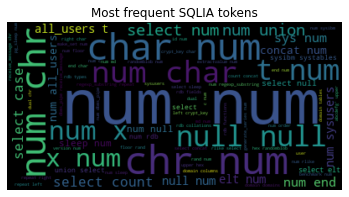

In [17]:
# Source: https://www.datacamp.com/community/tutorials/wordcloud-python
stopwords = set(STOPWORDS)
stopwords.update(invalid_tokens)

sqlia_text = " ".join(mod_data[mod_data['SQLIA']==True]['query_proc'].to_list())
sqlia_wordcloud = WordCloud().generate(sqlia_text)

normal_text = " ".join(mod_data[mod_data['SQLIA']==False]['query_proc'].to_list())
normal_wordcloud = WordCloud().generate(normal_text)

plt.figure()
plt.imshow(sqlia_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent SQLIA tokens")
plt.show()

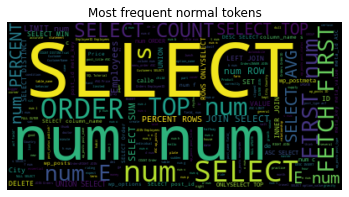

In [18]:
plt.figure()
plt.imshow(normal_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent normal tokens")
plt.show()

### Splitting into train and test sets

In [19]:
def prepare_data(data):
    
    X = data.drop('SQLIA', axis=1)
    y = data['SQLIA'].apply(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=0)    
    X_tr = X_tr.drop('query_proc', axis=1)
    X_te = X_te.drop('query_proc', axis=1)
    return X_tr, X_te, y_tr, y_te

In [20]:
X_train, X_test, y_train, y_test = prepare_data(mod_data)

### Top bi-grams and tri-grams

From EDA, we have observed that not all tokens signify anything meaningful. E.g. tokens like "SELECT", "ALL". We will use these tokens as stop words for our vectorizer.

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), min_df=10, stop_words=invalid_tokens)
X_train_tfidf = vectorizer.fit_transform(mod_data['query_proc'].loc[X_train.index])
X_train_tfidf.shape

(23178, 351)

In [22]:
X_test_tfidf = vectorizer.transform(mod_data['query_proc'].loc[X_test.index])
X_test_tfidf.shape

(7727, 351)

In [23]:
vec_features = vectorizer.get_feature_names()
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vec_features, index=X_train.index)
print(vec_features[:50])

['abcdefg upper', 'abcdefg upper hex', 'acf field', 'acf field wp_posts', 'all_users all_users', 'all_users all_users all_users', 'analyse extractvalue', 'analyse extractvalue concat', 'asc wp_posts', 'asc wp_posts post_title', 'avg price', 'banner version', 'banner version rownum', 'benchmark md', 'boolean mode', 'call regexp_substring', 'call regexp_substring repeat', 'case when', 'case when then', 'cast chr', 'cast chr chr', 'cast int', 'cast int dual', 'char case', 'char case when', 'char char', 'char char case', 'char char char', 'char char else', 'char char end', 'char char regexp_substring', 'char else', 'char else char', 'char end', 'char end char', 'char end information_schema', 'char regexp_substring', 'char regexp_substring repeat', 'character_sets end', 'chr case', 'chr case when', 'chr chr', 'chr chr case', 'chr chr chr', 'chr chr dual', 'chr chr numeric', 'chr dual', 'chr numeric', 'city country', 'collations rdb']


In [24]:
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vec_features, index=X_test.index)

In [25]:
# finding top 20 tokens

def find_top(is_sqlia, N):
    
    '''
    This function finds the top N tokens which are most frequent in given query type
    Parameter is_sqlia: (bool) True if we want the top N tokens of SQLIA queries
    Returns the top N tokens as a dataframe, with their respective count values
    '''
    df = X_train_tfidf[y_train==is_sqlia]
    return df.sum(axis=0).sort_values(ascending=False).head(N)
sqlia_top_20 = find_top(True, 20)
normal_top_20 = find_top(False, 20)

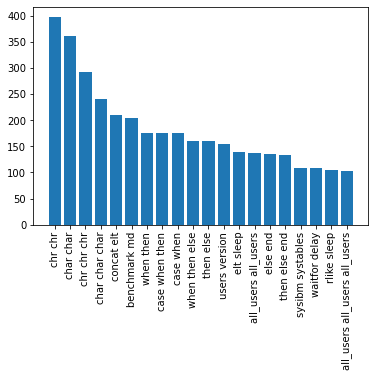

In [26]:
plt.bar(sqlia_top_20.index, sqlia_top_20.values)
plt.xticks(rotation=90)
plt.show()

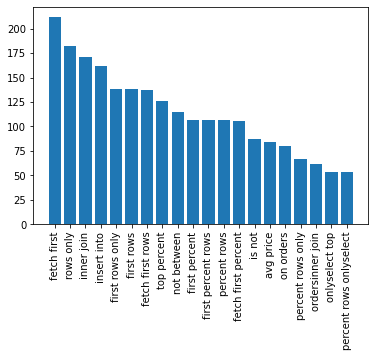

In [27]:
plt.bar(normal_top_20.index, normal_top_20.values)
plt.xticks(rotation=90)
plt.show()

### Building a baseline model - Naive Bayes

We will use the features we got from EDA to train a Naive Bayes classifier.

In [28]:
X_train.head()

,char_len,word_len,has_keywords,is_complete_query,one_word,always_true,sent_pol,entropy
24721,83,14,1,1,0,0,0.1,3.521641
658,49,9,1,1,0,0,0.0,2.947703
2624,61,12,1,0,0,1,0.0,3.251629
3912,42,8,1,0,0,1,0.0,2.750000
27555,33,5,1,1,0,0,0.3,2.321928


In [29]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_scores = gnb.predict_proba(X_test)

In [30]:
y_pred = gnb.predict(X_test)
f1_score(y_test, y_pred)

0.7662218972765491

In [31]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])

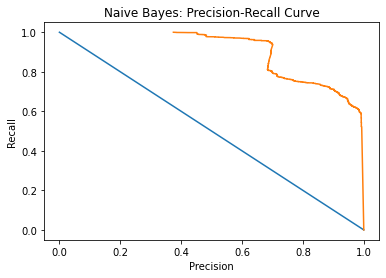

In [32]:
plt.plot([0, 1], [1, 0])
plt.plot(precision, recall)
plt.title("Naive Bayes: Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [33]:
f1 = (2 * precision * recall)/(precision + recall)

In [34]:
argmax_base = f1.argmax()
argmax_base

1135

In [35]:
def print_values(arg):
    print("Threshold:", thresholds[arg])
    print("Precision:", precision[arg])
    print("Recall:", recall[arg])
    print("F1-score:", f1[arg])

In [36]:
print_values(argmax_base)

Threshold: 0.09341821859871466
Precision: 0.6984126984126984
Recall: 0.946236559139785
F1-score: 0.8036529680365297


In [37]:
result = pd.DataFrame(index=['Naive Bayes'], data={'F1-score':[f1[argmax_base]], 'Threshold':[thresholds[argmax_base]]})
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418


In [38]:
def addResult(model, f1, th):
    result.loc[model] = [f1, th]

###### Downsampled

In [39]:
X_train_d, X_test_d, y_train_d, y_test_d = prepare_data(mod_data_down)

In [40]:
gnb = GaussianNB()
gnb.fit(X_train_d, y_train_d)
y_scores_d = gnb.predict_proba(X_test_d)
precision, recall, thresholds = precision_recall_curve(y_test_d, y_scores_d[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.11036146423765597
Precision: 0.7268211920529801
Recall: 0.9430719656283566
F1-score: 0.8209443665264142


In [41]:
addResult('Naive Bayes down', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361


###### Upsampled

In [42]:
X_train_u, X_test_u, y_train_u, y_test_u = prepare_data(mod_data_up)

In [43]:
gnb = GaussianNB()
gnb.fit(X_train_u, y_train_u)
y_scores_u = gnb.predict_proba(X_test_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores_u[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.13094098465818033
Precision: 0.7399488728793865
Recall: 0.9487485101311085
F1-score: 0.8314401357879618


In [44]:
addResult('Naive Bayes up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361
Naive Bayes up,0.831440,0.130941


### Random Forest model

In [45]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train, y_train)
y_scores = rdf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.5946318504051553
Precision: 0.9882266372332598
Recall: 0.9627240143369176
F1-score: 0.9753086419753086


In [46]:
addResult('Random Forest', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361
Naive Bayes up,0.831440,0.130941
Random Forest,0.975309,0.594632


##### Upsampled

In [47]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train_u, y_train_u)
y_scores_u = rdf.predict_proba(X_test_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores_u[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.6152355699855699
Precision: 0.9902705989662511
Recall: 0.9705005959475567
F1-score: 0.9802859292701279


In [48]:
addResult('Random Forest up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361
Naive Bayes up,0.831440,0.130941
Random Forest,0.975309,0.594632
Random Forest up,0.980286,0.615236


### LightGBM

In [49]:
# Source: https://stackoverflow.com/questions/51139150/how-to-write-custom-f1-score-metric-in-light-gbm-python-in-multiclass-classifica

def fscore(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

In [50]:
# Source: https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

train_data=lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore)

[LightGBM] [Info] Number of positive: 8587, number of negative: 14591
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 23178, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370481 -> initscore=-0.530155
[LightGBM] [Info] Start training from score -0.530155
[1]	valid_0's binary_logloss: 0.645469	valid_0's f1_score: 0.958864
[2]	valid_0's binary_logloss: 0.636914	valid_0's f1_score: 0.958864
[3]	valid_0's binary_logloss: 0.628549	valid_0's f1_score: 0.958864
[4]	valid_0's binary_logloss: 0.620428	valid_0's f1_score: 0.95897
[5]	valid_0's binary_logloss: 0.612483	valid_0's f1_score: 0.959015
[6]	valid_0's binary_logloss: 0.604648	valid_0's f1_score: 0.958814
[7]	valid_0's binary_logloss: 0.596

In [51]:
y_scores = lgbm.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.376101652230953
Precision: 0.9814333457111029
Recall: 0.9473118279569892
F1-score: 0.9640707641801932


In [52]:
addResult('LightGBM', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361
Naive Bayes up,0.831440,0.130941
Random Forest,0.975309,0.594632
Random Forest up,0.980286,0.615236
LightGBM,0.964071,0.376102


###### Upsampled

In [53]:
def fscore_up(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

In [55]:
train_data=lgb.Dataset(X_train_u,label=y_train_u)
test_data = lgb.Dataset(X_test_u, label=y_test_u)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore_up)
y_scores = lgbm.predict(X_test_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Info] Number of positive: 10021, number of negative: 14657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406070 -> initscore=-0.380235
[LightGBM] [Info] Start training from score -0.380235
[1]	valid_0's binary_logloss: 0.667247	valid_0's f1_score: 0.962408
[2]	valid_0's binary_logloss: 0.658581	valid_0's f1_score: 0.962408
[3]	valid_0's binary_logloss: 0.650098	valid_0's f1_score: 0.962408
[4]	valid_0's binary_logloss: 0.641793	valid_0's f1_score: 0.962408
[5]	valid_0's binary_logloss: 0.633658	valid_0's f1_score: 0.962408
[6]	valid_0's binary_logloss: 0.625694	valid_0's f1_score: 0.962408
[7]	valid_0's binary_logloss: 0.6

In [56]:
addResult('LightGBM up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,0.093418
Naive Bayes down,0.820944,0.110361
Naive Bayes up,0.831440,0.130941
Random Forest,0.975309,0.594632
Random Forest up,0.980286,0.615236
LightGBM,0.964071,0.376102
LightGBM up,0.967665,0.340514


### Model with word vectors

#### Tfidf vectorizer

In [57]:
X_train_tfidf = pd.concat((X_train, X_train_tfidf), axis=1)
X_test_tfidf = pd.concat((X_test, X_test_tfidf), axis=1)

In [58]:
X_train_tfidf.shape

(23178, 359)

In [59]:
X_test_tfidf.shape

(7727, 359)

In [60]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), min_df=10, stop_words=invalid_tokens)
X_tr_tfidf = vectorizer.fit_transform(mod_data_up['query_proc'].iloc[X_train_u.index])
X_te_tfidf = vectorizer.transform(mod_data_up['query_proc'].iloc[X_test_u.index])
X_tr_tfidf = pd.DataFrame(X_tr_tfidf.toarray(), columns=vectorizer.get_feature_names(), index=X_train_u.index)
X_te_tfidf = pd.DataFrame(X_te_tfidf.toarray(), columns=vectorizer.get_feature_names(), index=X_test_u.index)
X_train_tfidf_u = pd.concat((X_train_u, X_tr_tfidf), axis=1)
X_test_tfidf_u = pd.concat((X_test_u, X_te_tfidf), axis=1)

In [61]:
X_train_tfidf_u.shape

(24678, 380)

In [62]:
X_test_tfidf_u.shape

(8227, 380)

##### 1. Naive Bayes

In [63]:
gnb = GaussianNB()
gnb.fit(X_train_tfidf, y_train)
y_scores = gnb.predict_proba(X_test_tfidf)

y_pred = gnb.predict(X_test_tfidf)
f1_score(y_test, y_pred)

0.6701620591039085

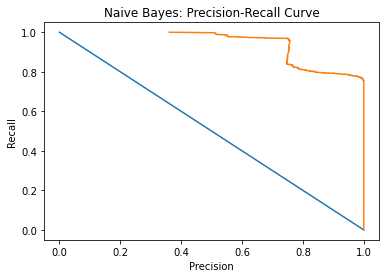

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
plt.plot([0, 1], [1, 0])
plt.plot(precision, recall)
plt.title("Naive Bayes: Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [65]:
f1 = (2 * precision * recall)/(precision + recall)
argmax_tfidf = f1.argmax()
argmax_tfidf

1665

In [66]:
print_values(argmax_tfidf)

Threshold: 1.1287998952461157e-148
Precision: 0.9898943500229674
Recall: 0.7724014336917563
F1-score: 0.8677269981880411


As we can see, the precision is given more preference over recall in this case. Although this model has high f1 score, it could be at the cost of undetected SQLIA. Let's look for a better threshold.

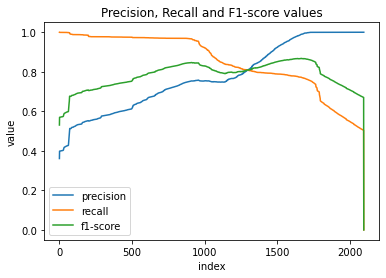

In [67]:
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1-score')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.title("Precision, Recall and F1-score values")
plt.show()

###### Observations

1. Beyond about 1300, recall is going really down although precision and f1 score are increasing.
2. Below 1300, recall is high while f1 score and precision are low.

In order to get a good recall while also maintaining f1 score, we need to find the highest f1 score within the 0-1300 indices.

In [68]:
argmax_tfidf_high_recall = f1[:1300].argmax()
argmax_tfidf_high_recall

909

In [69]:
print_values(argmax_tfidf_high_recall)

Threshold: 4.6286233187473275e-151
Precision: 0.7536312849162011
Recall: 0.9670250896057347
F1-score: 0.8470957613814756


Now we have a high recall. Although F1-score is lower than before, it is still higher than the baseline model.

In [70]:
addResult('TFIDF - NB', f1[argmax_tfidf_high_recall], thresholds[argmax_tfidf_high_recall])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151


##### Upsampled

In [71]:
gnb = GaussianNB()
gnb.fit(X_train_tfidf_u, y_train_u)
y_scores_u = gnb.predict_proba(X_test_tfidf_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores_u[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 1.53238963153984e-156
Precision: 0.9564343163538874
Recall: 0.8504171632896305
F1-score: 0.9003154574132493


In [72]:
addResult('TFIDF - NB up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156


#### 2. Random forest

In [73]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train_tfidf, y_train)
y_scores = rdf.predict_proba(X_test_tfidf)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.6034761904761903
Precision: 0.9923048735800659
Recall: 0.9706093189964158
F1-score: 0.9813371987678927


In [74]:
addResult('TFIDF - RF', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


##### Upsampled

In [75]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train_tfidf_u, y_train_u)
y_scores = rdf.predict_proba(X_test_tfidf_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.5510396825396826
Precision: 0.9897528631705846
Recall: 0.9785458879618594
F1-score: 0.9841174707821395


In [76]:
addResult('TFIDF - RF up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


#### 3. LightGBM

In [77]:
def fscore(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train_tfidf,label=y_train)
test_data = lgb.Dataset(X_test_tfidf, label=y_test)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore)

y_scores = lgbm.predict(X_test_tfidf)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8587, number of negative: 14591
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2002
[LightGBM] [Info] Number of data points in the train set: 23178, number of used features: 329
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370481 -> initscore=-0.530155
[LightGBM] [Info] Start training from score -0.530155
[1]	valid_0's binary_logloss: 0.645338	valid_0's f1_score: 0.965025
[2]	valid_0's binary_logloss: 0.636655	valid_0's f1_score: 0.965025
[3]	valid_0's binary_logloss: 0.628166	valid_0's f1_score: 0.965025
[4]	valid_0's binary_logloss: 0.619936	valid_0's f1_score: 0.965201
[5]	val

In [78]:
addResult('TFIDF - LightGBM', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


###### Upsampled

In [79]:
def fscore_up(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train_tfidf_u,label=y_train_u)
test_data = lgb.Dataset(X_test_tfidf_u, label=y_test_u)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore_up)
y_scores = lgbm.predict(X_test_tfidf_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10021, number of negative: 14657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 324
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406070 -> initscore=-0.380235
[LightGBM] [Info] Start training from score -0.380235
[1]	valid_0's binary_logloss: 0.667168	valid_0's f1_score: 0.966976
[2]	valid_0's binary_logloss: 0.658426	valid_0's f1_score: 0.966976
[3]	valid_0's binary_logloss: 0.649888	valid_0's f1_score: 0.966976
[4]	valid_0's binary_logloss: 0.641502	valid_0's f1_score: 0.966976
[5]	valid_0's binary_logloss: 0.633296	valid_0's f1_score: 0.966976
[6

In [80]:
addResult('TFIDF - LightGBM up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


#### Glove Vectors

In [81]:
glove_docs = pd.read_csv('EDA_query_vectors_glove.csv', index_col=0)
glove_docs.shape

(30905, 50)

In [82]:
glove_docs.index = mod_data.index

In [87]:
X_train, X_test, y_train, y_test = prepare_data(mod_data)
X_train = pd.concat((X_train, glove_docs.loc[X_train.index]), axis=1)
X_test = pd.concat((X_test, glove_docs.loc[X_test.index]), axis=1)

In [88]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_scores = gnb.predict_proba(X_test)

y_pred = gnb.predict(X_test)
f1_score(y_test, y_pred)

0.831608280254777

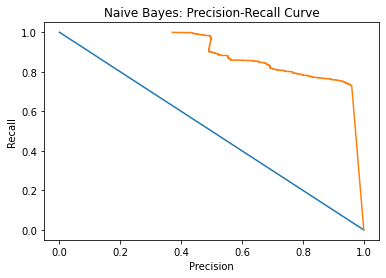

In [89]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
plt.plot([0, 1], [1, 0])
plt.plot(precision, recall)
plt.title("Naive Bayes: Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [90]:
f1 = (2 * precision * recall)/(precision + recall)
argmax_glove = f1.argmax()
argmax_glove

3853

In [91]:
print_values(argmax_glove)

Threshold: 0.06730616104939123
Precision: 0.9320302087960907
Recall: 0.7519713261648745
F1-score: 0.8323745288633208


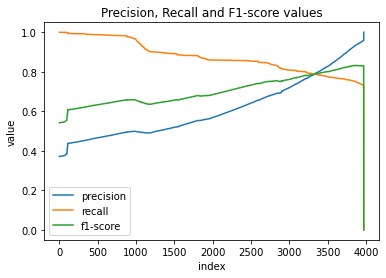

In [92]:
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1-score')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.title("Precision, Recall and F1-score values")
plt.show()

As we can see, trying to increase the recall would reduce the F1 score substantially.

In [93]:
addResult('Glove - NB', f1[argmax_glove], thresholds[argmax_glove])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


##### Random Forest

In [94]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train, y_train)
y_scores = rdf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.405
Precision: 0.9956818999640158
Recall: 0.9917562724014337
F1-score: 0.9937152091937511


In [95]:
addResult('Glove - RF', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


#### LightGBM

In [96]:
def fscore(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore)

y_scores = lgbm.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Info] Number of positive: 8587, number of negative: 14591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13578
[LightGBM] [Info] Number of data points in the train set: 23178, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370481 -> initscore=-0.530155
[LightGBM] [Info] Start training from score -0.530155
[1]	valid_0's binary_logloss: 0.645135	valid_0's f1_score: 0.970562
[2]	valid_0's binary_logloss: 0.636287	valid_0's f1_score: 0.969883
[3]	valid_0's binary_logloss: 0.627641	valid_0's f1_score: 0.96905
[4]	valid_0's binary_logloss: 0.619158	valid_0's f1_score: 0.970025
[5]	valid_0's binary_logloss: 0.61093	valid_0's f1_score: 0.9702
[6]	valid_0's binary_logloss: 0.602872	valid_0's f1_score: 0.97053
[7]	valid_0's binary_logloss: 0.594996	valid_0's f1_score: 0.970058
[8]	valid_0's binary_logloss: 0.

In [97]:
addResult('Glove - LightGBM', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


###### Upsampled

In [98]:
def fscore_up(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train_u,label=y_train_u)
test_data = lgb.Dataset(X_test_u, label=y_test_u)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore_up)
y_scores = lgbm.predict(X_test_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Info] Number of positive: 10021, number of negative: 14657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406070 -> initscore=-0.380235
[LightGBM] [Info] Start training from score -0.380235
[1]	valid_0's binary_logloss: 0.667247	valid_0's f1_score: 0.962408
[2]	valid_0's binary_logloss: 0.658581	valid_0's f1_score: 0.962408
[3]	valid_0's binary_logloss: 0.650098	valid_0's f1_score: 0.962408
[4]	valid_0's binary_logloss: 0.641793	valid_0's f1_score: 0.962408
[5]	valid_0's binary_logloss: 0.633658	valid_0's f1_score: 0.962408
[6]	valid_0's binary_logloss: 0.625694	valid_0's f1_score: 0.962408
[7]	valid_0's binary_logloss: 0.6

In [99]:
addResult('Glove - LightGBM up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


#### Word2vec

In [100]:
vec_len = 300
def get_doc_vec(q):
    
    '''
    This function returns a query's embedding by summing up the vectors for each word.
    Parameter q: (str) Query string whose vector embedding is required
    Returns doc_vec: (numpy array) Vector embedding of given query
    '''
    doc_vec = np.zeros(vec_len)
    for w in q.split():
        if w2v_vectors.has_index_for(w):
            doc_vec += w2v_vectors.get_vector(w)
    return doc_vec

In [101]:
if os.path.isfile('Modeling_query_vectors_w2v.csv'):
    doc_vecs = pd.read_csv('Modeling_query_vectors_w2v.csv', index_col=0)
else:
    w2v_vectors = api.load('word2vec-google-news-300') # loading the w2v vectors
    doc_vecs = np.zeros((mod_data.shape[0], vec_len))
    for i in range(mod_data.shape[0]):
        q = mod_data.iloc[i]['small']
        doc_vec = get_doc_vec(q)
        doc_vecs[i] = doc_vec
    doc_vecs = pd.DataFrame(doc_vecs)
    doc_vecs.to_csv('Modeling_query_vectors_w2v.csv')

In [102]:
doc_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.023438,-0.140625,0.161133,0.217773,-0.100586,0.082031,0.129883,0.045898,0.043457,0.033691,...,-0.074707,0.244141,0.044678,0.057617,0.052002,0.027954,0.003647,-0.156250,-0.002090,0.079590
1,-0.064453,-0.186676,-0.021484,0.799072,-1.237732,-0.032593,-0.016602,-0.147430,1.131836,0.054749,...,-0.355469,1.240723,-0.578491,0.314331,-0.098450,0.784180,0.260254,-0.192719,-0.648315,-0.666897
2,-1.062195,0.678606,-0.282471,2.051453,-1.019592,0.383118,-0.235107,-1.989136,1.239990,0.404785,...,0.020386,0.979614,-0.202723,0.738525,-0.355835,-0.558472,0.252266,-1.541260,-0.885254,0.516724
3,-0.640411,-0.056693,-0.018116,2.024963,-0.615417,0.741943,-0.597885,-1.658569,0.667664,0.082458,...,0.273804,1.689545,-0.019533,0.846680,0.291870,-0.869873,-0.124588,-1.480591,-1.098038,0.852005
4,-0.114044,-0.174491,-0.078419,1.751038,-0.888123,0.367554,-0.392563,-1.219604,0.780029,0.170593,...,0.288696,1.249847,-0.243654,0.549805,0.290405,-0.211914,-0.036758,-1.123657,-0.711563,0.426933


In [103]:
doc_vecs.index = mod_data.index

In [105]:
X_train, X_test, y_train, y_test = prepare_data(mod_data)
X_train = pd.concat((X_train, doc_vecs.loc[X_train.index]), axis=1)
X_test = pd.concat((X_test, doc_vecs.loc[X_test.index]), axis=1)

##### Naive Bayes

In [106]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_scores = gnb.predict_proba(X_test)

y_pred = gnb.predict(X_test)
f1_score(y_test, y_pred)

0.7444933920704846

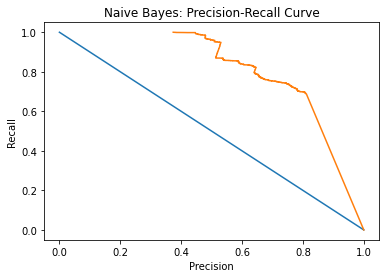

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
plt.plot([0, 1], [1, 0])
plt.plot(precision, recall)
plt.title("Naive Bayes: Precision-Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [108]:
f1 = (2 * precision * recall)/(precision + recall)
argmax_w2v = f1.argmax()
argmax_w2v

3389

In [109]:
print_values(argmax_w2v)

Threshold: 0.9999999999985576
Precision: 0.8049586776859504
Recall: 0.6982078853046595
F1-score: 0.7477927063339732


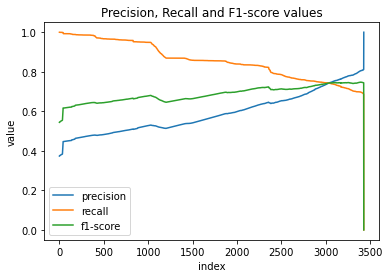

In [110]:
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1-score')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.title("Precision, Recall and F1-score values")
plt.show()

In [111]:
addResult('W2V - NB', f1[argmax_w2v], thresholds[argmax_w2v])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


##### Random Forest

In [112]:
rdf = RandomForestClassifier(min_samples_split=5, random_state=0)
rdf.fit(X_train, y_train)
y_scores = rdf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

Threshold: 0.4023044733044735
Precision: 0.9974610083424011
Recall: 0.985663082437276
F1-score: 0.9915269515053181


In [113]:
addResult('W2V - RF', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


#### LightGBM

In [114]:
def fscore(y_scores, dtrain):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore)

y_scores = lgbm.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Info] Number of positive: 8587, number of negative: 14591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77328
[LightGBM] [Info] Number of data points in the train set: 23178, number of used features: 308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370481 -> initscore=-0.530155
[LightGBM] [Info] Start training from score -0.530155
[1]	valid_0's binary_logloss: 0.645125	valid_0's f1_score: 0.971956
[2]	valid_0's binary_logloss: 0.636252	valid_0's f1_score: 0.971325
[3]	valid_0's binary_logloss: 0.627562	valid_0's f1_score: 0.971532
[4]	valid_0's binary_logloss: 0.619053	valid_0's f1_score: 0.972037
[5]	valid_0's binary_logloss: 0.610731	valid_0's f1_score: 0.97201
[6]	valid_0's binary_logloss: 0.602569	valid_0's f1_score: 0.972101
[7]	valid_0's binary_logloss: 0.594577	valid_0's f1_score: 0.972212
[8]	valid_0's binary_loglos

In [115]:
addResult('W2V - LightGBM', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


###### Upsampled

In [116]:
def fscore_up(y_scores, dtrain):
    precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
    f1 = (2 * precision * recall)/(precision + recall)
    return 'f1_score', f1.max(), True

train_data=lgb.Dataset(X_train_u,label=y_train_u)
test_data = lgb.Dataset(X_test_u, label=y_test_u)
param = {'objective':'binary', 'learning_rate':0.01}
lgbm=lgb.train(param, train_data, valid_sets=[test_data], feval=fscore_up)
y_scores = lgbm.predict(X_test_u)
precision, recall, thresholds = precision_recall_curve(y_test_u, y_scores)
f1 = (2 * precision * recall)/(precision + recall)
print_values(f1.argmax())

[LightGBM] [Info] Number of positive: 10021, number of negative: 14657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406070 -> initscore=-0.380235
[LightGBM] [Info] Start training from score -0.380235
[1]	valid_0's binary_logloss: 0.667247	valid_0's f1_score: 0.962408
[2]	valid_0's binary_logloss: 0.658581	valid_0's f1_score: 0.962408
[3]	valid_0's binary_logloss: 0.650098	valid_0's f1_score: 0.962408
[4]	valid_0's binary_logloss: 0.641793	valid_0's f1_score: 0.962408
[5]	valid_0's binary_logloss: 0.633658	valid_0's f1_score: 0.962408
[6]	valid_0's binary_logloss: 0.625694	valid_0's f1_score: 0.962408
[7]	valid_0's binary_logloss: 0.617886	valid_0's f1_score: 0.962408
[8]	valid_0's binary_logloss:

In [117]:
addResult('W2V - LightGBM up', f1.max(), thresholds[f1.argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


### BERT

We are going to train a BERT model from scratch on our processed text data. 

The model we are using:
- is a small BERT model
- has 2 residual blocks
- has a hidden size of 512
- has 8 attention heads

In [10]:
# Source: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

# creating tensor dataset
train_index = y_train.index
test_index = y_test.index
train_ds = tf.data.Dataset.from_tensor_slices((pd.DataFrame(mod_data['query_proc'][train_index]), pd.DataFrame(y_train)))
test_ds = tf.data.Dataset.from_tensor_slices((pd.DataFrame(mod_data['query_proc'][test_index]), pd.DataFrame(y_test)))

# we get the preprocessing and encoder models from these URLs
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [12]:
def build_classifier_model():
    '''
    Builds classifier model using BERT as a KerasLayer.
    We use the pooled_output from BERT layer for classification.
    pooled_output represents each query as a single decimal value.
    Returns: (tf.keras.Model) model to be used for classifying
    '''
    text_input = layers.Input(shape=(), dtype=tf.string, name='inputs')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
# instantiating classifier model and defining hyperparameters

classifier_model = build_classifier_model()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [15]:
# compiling model

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [16]:
# training classifier
# epoch=1
classifier_model.fit(x=train_ds,
                      validation_data=test_ds,
                      epochs=1)

classifier_model.save_weights('BERT_epoch_1.h5')
print('Model saved')

23178/23178 [==============================] - 1030s 44ms/step - loss: 0.0612 - binary_accuracy: 0.9862 - val_loss: 0.0209 - val_binary_accuracy: 0.9973
Model saved


In [17]:
# epoch=2
classifier_model.fit(x=train_ds,
                       validation_data=test_ds,
                       epochs=1)

classifier_model.save_weights('BERT_epoch_2.h5')
print('Model saved')

23178/23178 [==============================] - 1006s 43ms/step - loss: 0.0116 - binary_accuracy: 0.9984 - val_loss: 0.0163 - val_binary_accuracy: 0.9983
Model saved


In [18]:
# epoch=3
classifier_model.fit(x=train_ds,
                       validation_data=test_ds,
                       epochs=1)

classifier_model.save_weights('BERT_epoch_3.h5')
print('Model saved')

23178/23178 [==============================] - 998s 43ms/step - loss: 0.0050 - binary_accuracy: 0.9993 - val_loss: 0.0163 - val_binary_accuracy: 0.9983
Model saved


In [19]:
# epoch=4
classifier_model.fit(x=train_ds,
                       validation_data=test_ds,
                       epochs=1)

classifier_model.save_weights('BERT_epoch_4.h5')
print('Model saved')

23178/23178 [==============================] - 998s 43ms/step - loss: 0.0050 - binary_accuracy: 0.9992 - val_loss: 0.0163 - val_binary_accuracy: 0.9983
Model saved


In [20]:
# epoch=5
classifier_model.fit(x=train_ds,
                       validation_data=test_ds,
                       epochs=1)

classifier_model.save_weights('BERT_epoch_5.h5')
print('Model saved')

23178/23178 [==============================] - 1006s 43ms/step - loss: 0.0046 - binary_accuracy: 0.9992 - val_loss: 0.0163 - val_binary_accuracy: 0.9983
Model saved


As we can see, the validation accuracy is not increasing anymore. Hence we will stop training.

#### Predictions using BERT

In [29]:
# getting probability values for test dataset predictions

y_scores = classifier_model.predict(pd.DataFrame(mod_data['query_proc'][test_index]))

In [55]:
# storing f1-score, precision and recall for different threshold values

with open('BERT_metrics.csv', 'w') as f:
    f.write("Threshold, F1-Score, Precision, Recall\n")
    for th in np.arange(0, 1, 0.1):
        y_pred = (y_scores > th).astype(int)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        f.write("{0:.1f},{1:.4f},{2:.4f},{3:.4f}\n".format(th, fscore, precision, recall))

In [118]:
BERT_metrics_df = pd.read_csv('BERT_metrics.csv')
BERT_metrics_df

,Threshold,F1-Score,Precision,Recall
0,0.0,0.9975,0.9971,0.9978
1,0.1,0.9975,0.9971,0.9978
2,0.2,0.9975,0.9971,0.9978
3,0.3,0.9977,0.9975,0.9978
4,0.4,0.9977,0.9975,0.9978
5,0.5,0.9977,0.9975,0.9978
6,0.6,0.9977,0.9975,0.9978
7,0.7,0.9977,0.9975,0.9978
8,0.8,0.9977,0.9975,0.9978
9,0.9,0.9977,0.9975,0.9978


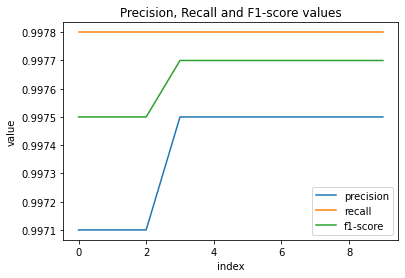

In [157]:
plt.plot(BERT_metrics_df[' Precision'], label='precision')
plt.plot(BERT_metrics_df[' Recall'], label='recall')
plt.plot(BERT_metrics_df[' F1-Score'], label='f1-score')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.title("Precision, Recall and F1-score values")
plt.show()

In [119]:
addResult('Small BERT', BERT_metrics_df[' F1-Score'].max(), BERT_metrics_df['Threshold'][BERT_metrics_df[' F1-Score'].argmax()])
result

,F1-score,Threshold
Naive Bayes,0.803653,9.341822e-02
Naive Bayes down,0.820944,1.103615e-01
Naive Bayes up,0.831440,1.309410e-01
Random Forest,0.975309,5.946319e-01
Random Forest up,0.980286,6.152356e-01
LightGBM,0.964071,3.761017e-01
LightGBM up,0.967665,3.405136e-01
TFIDF - NB,0.847096,4.628623e-151
TFIDF - NB up,0.900315,1.532390e-156
TFIDF - RF,0.981337,6.034762e-01


###### Highest F1-score by model

In [125]:
result.sort_values(by='F1-score', ascending=False).head()

,F1-score,Threshold
Small BERT,0.997700,0.300000
Glove - RF,0.993715,0.405000
W2V - RF,0.991527,0.402304
TFIDF - RF up,0.984117,0.551040
Glove - LightGBM,0.981646,0.477216


In [21]:
joblib.dump(classifier_model, 'model.pkl')
print('model.pkl saved')

model.pkl saved


## Conclusion

- The BERT model has the highest F1-score of 99.77 with a threshold of 0.3
- Random Forest, LightGBM work better for this dataset than Naive Bayes
- Upsampling led to some improvement in results for TFIDF
- Glove word vectors performed better than the rest